# NLP Capstone Project: Mapping the Emotional Arc of a Harry Potter Novel

In [41]:
import nltk
import re
import pandas as pd
import numpy as np

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [28]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Text Preparation

In [29]:
with open("/content/Harry Potter And The Goblet Of Fire.txt", "r", encoding="utf-8") as f:
    text = f.read()

# Find chapter start positions
pattern = r'(CHAPTER [A-Z ]+ - [A-Z ]+)'  # matches full chapter titles
matches = list(re.finditer(pattern, text))

# Extract chapters using the match indices
chapters = []
for i in range(len(matches)):
    start = matches[i].start()
    end = matches[i+1].start() if i+1 < len(matches) else len(text)
    chapter_text = text[start:end].strip()
    chapters.append(chapter_text)

# Step 4: Store in DataFrame
df = pd.DataFrame({'chapter': list(range(1, len(chapters)+1)), 'text': chapters})
df.head(3)

,chapter,text
0,1,CHAPTER ONE - THE RIDDLE HOUSE\nThe villagers ...
1,2,CHAPTER TWO - THE SCAR\nHarry lay flat on his ...
2,3,CHAPTER THREE - THE INVITATION\nBy the time Ha...


In [30]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation/numbers
    tokens = word_tokenize(text)  # tokenize
    tokens = [t for t in tokens if t not in stop_words]  # remove stopwords
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]  # lemmatize
    return " ".join(lemmas)

# Apply it to your chapter texts
df['clean_text'] = df['text'].apply(preprocess)
df[['chapter', 'clean_text']].head()

,chapter,clean_text
0,1,chapter one riddle house villager little hangl...
1,2,chapter two scar harry lay flat back breathing...
2,3,chapter three invitation time harry arrived ki...
3,4,chapter four back burrow twelve oclock next da...
4,5,chapter five weasleys wizard wheeze harry spun...


### Sentiment Analysis with VADER

In [31]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

df['compound_score'] = df['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
df[['chapter', 'compound_score']].head()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,chapter,compound_score
0,1,-0.9992
1,2,-0.9942
2,3,0.9971
3,4,0.9394
4,5,0.9984


### Visualize the Emotional Arc

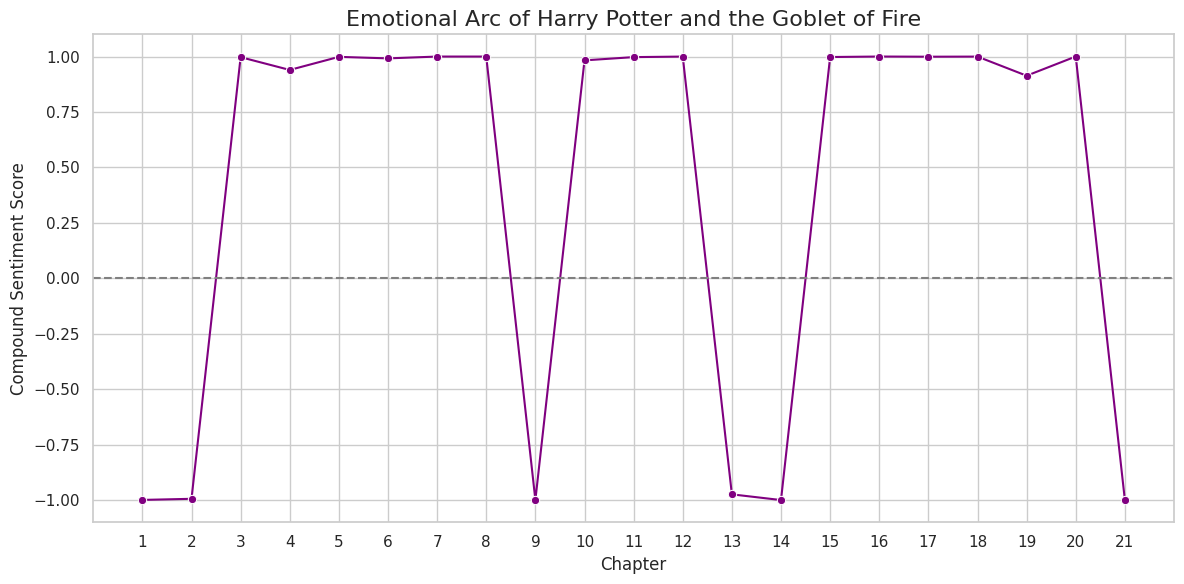

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional (prettier style)
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(x='chapter', y='compound_score', data=df, marker='o', color='purple')

plt.title('Emotional Arc of Harry Potter and the Goblet of Fire', fontsize=16)
plt.xlabel('Chapter', fontsize=12)
plt.ylabel('Compound Sentiment Score', fontsize=12)
plt.xticks(df['chapter'])  # show all chapters
plt.axhline(0, color='gray', linestyle='--')  # neutral line
plt.tight_layout()
plt.show()

### Interpretation

* The sentiment curve shows sharp swings between strong positive and strong negative values.

* Chapters 1–2 & 9, 13–14, 21 have very low sentiment scores (~–1), these likely align with darker themes (e.g., Voldemort’s presence, plot twists, or deaths).

* Chapters 3–8, 10–12, 15–20 are overwhelmingly positive (~1.0), possibly covering moments of lightness, triumph, or camaraderie.

* The repeated positive–negative pattern may reflect the Triwizard Tournament structure: a challenge (joy) followed by a consequence or danger (fear).

* The story ends on a highly negative note, hinting at the emotional weight of Cedric's death and Voldemort's return, setting a darker tone for future books.

* Overall, the emotional curve mirrors a narrative arc of rising action, high emotional variability, and a somber resolution.


### Character-Specific Sentiment Arcs

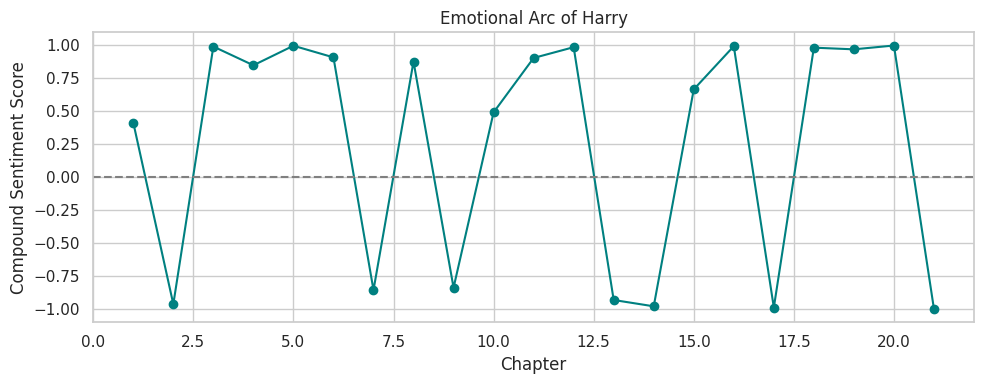

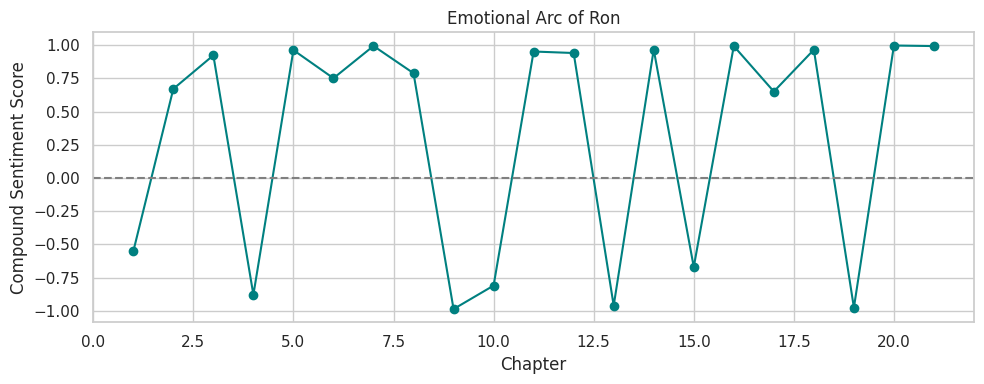

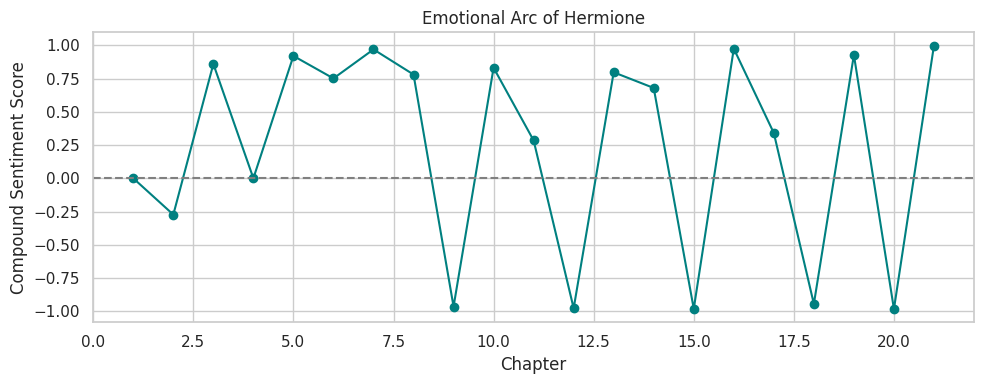

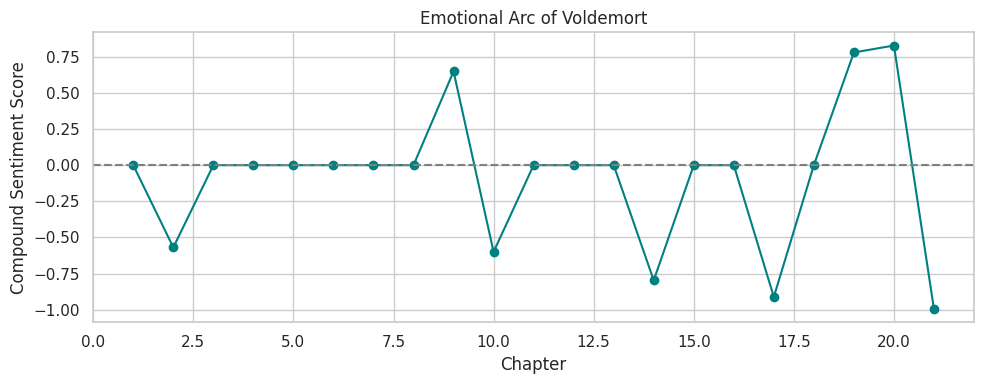

In [33]:
characters = ['Harry', 'Ron', 'Hermione', 'Voldemort']

# Extract only the lines where the character is mentioned
def extract_character_text(character, chapter_text):
    return ' '.join([line for line in chapter_text.split('\n') if character.lower() in line.lower()])

# Computing sentiment per chapter for one character
def get_character_sentiment(character):
    scores = []
    for text in df['text']:
        filtered = extract_character_text(character, text)
        score = sia.polarity_scores(filtered)['compound'] if filtered else 0
        scores.append(score)
    return scores

# Plotting
for character in characters:
    sentiment_scores = get_character_sentiment(character)
    plt.figure(figsize=(10, 4))
    plt.plot(df['chapter'], sentiment_scores, marker='o', color='teal')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"Emotional Arc of {character}")
    plt.xlabel('Chapter')
    plt.ylabel('Compound Sentiment Score')
    plt.tight_layout()
    plt.show()


### Word Clouds

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

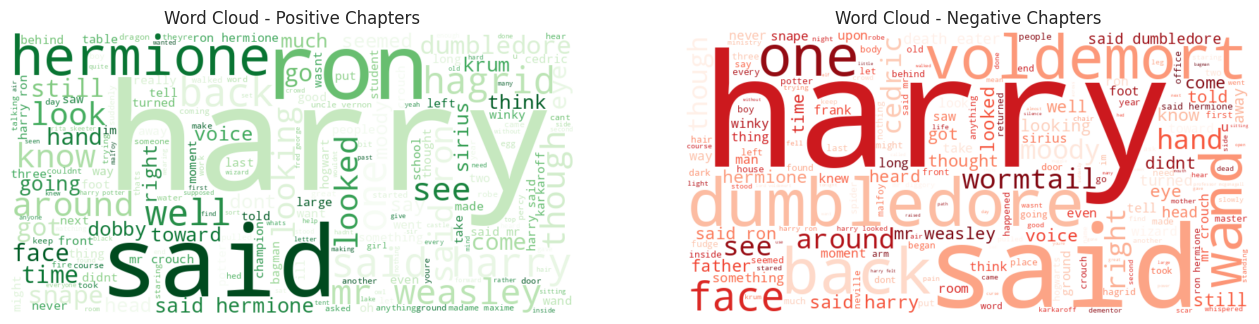

In [35]:
# Join clean text of positive and negative chapters
positive_text = " ".join(df[df['compound_score'] > 0.5]['clean_text'])
negative_text = " ".join(df[df['compound_score'] < -0.5]['clean_text'])

# Create word clouds
positive_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

# Plot them side-by-side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Chapters')

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Negative Chapters')
plt.show()

### Sentiment Distribution of Chapters

We’ll classify each chapter as:
* Negative: compound_score < -0.05
* Neutral: -0.05 ≤ compound_score ≤ 0.05
* Positive: compound_score > 0.05

/tmp/ipython-input-36-3862047224.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_label', data=df, palette={'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'})


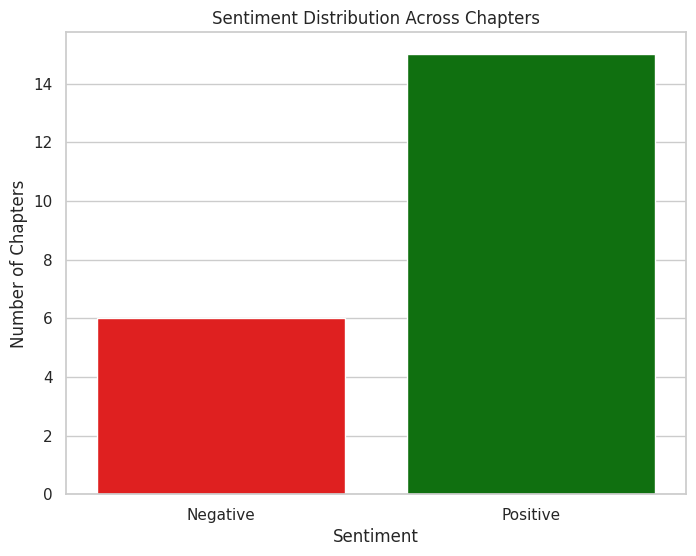

In [36]:
def get_sentiment_label(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['compound_score'].apply(get_sentiment_label)

# Bar Plot
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment_label', data=df, palette={'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'})

plt.title('Sentiment Distribution Across Chapters')
plt.xlabel('Sentiment')
plt.ylabel('Number of Chapters')
plt.show()

### Sentiment Distribution Heatmap by Chapter

In [37]:
# One-hot encode sentiment label
sentiment_matrix = pd.get_dummies(df['sentiment_label'])

# Add chapter numbers as index
sentiment_matrix.index = df['chapter']
sentiment_matrix = sentiment_matrix.T  # Transpose for heatmap formatting

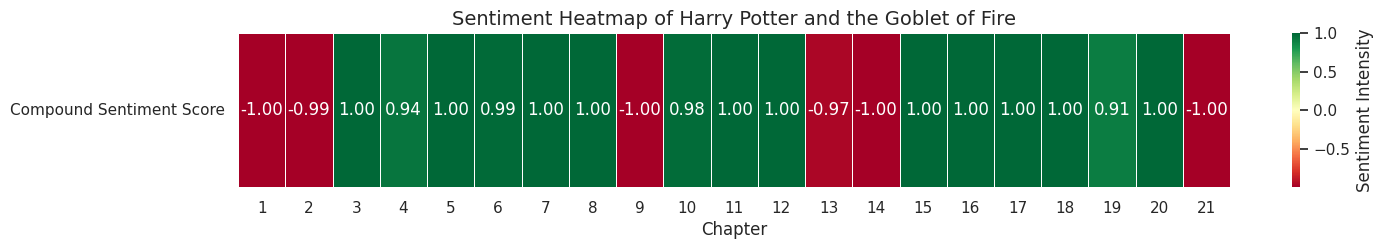

In [43]:
# Reshape compound scores into a 2D matrix with one row
compound_matrix = np.array([df['compound_score'].values])  # shape: (1, number of chapters)

# Heatmap
plt.figure(figsize=(16, 2))
sns.heatmap(compound_matrix, cmap="RdYlGn", annot=True, fmt=".2f", linewidths=0.5,
            xticklabels=df['chapter'], yticklabels=["Compound Sentiment Score"],
            cbar_kws={'label': 'Sentiment Intensity'})

plt.title("Sentiment Heatmap of Harry Potter and the Goblet of Fire", fontsize=14)
plt.xlabel("Chapter")
plt.yticks(rotation=0)
plt.show()

## Interpretive Summary
In this project, I performed sentiment analysis on Harry Potter and the Goblet of Fire using NLP techniques to understand the emotional flow of the story. Here's a breakdown of the results from each visualization:

### 1. Emotional Arc of the Novel
I plotted the compound sentiment score (from VADER) across the 21 chapters. The graph clearly shows emotional highs and lows throughout the story. Chapters like 1, 2, 9, 13, and 21 have very negative sentiment scores, which likely correspond to serious or dark events such as Voldemort’s return, deaths, or conflict. Chapters like 3 to 8 and 15 to 18 are more positive, possibly representing lighter or victorious moments in the narrative (e.g., Quidditch World Cup, early school life, or solving tasks).

### 2. Character-Specific Sentiment Arcs
I created separate plots for the emotional arcs of Harry, Ron, Hermione, and Voldemort.
* Harry’s arc swings between high and low sentiments, reflecting his journey from excitement (Triwizard Tournament) to fear (graveyard scene).
* Ron’s arc shows similar swings, especially due to his friendship tensions with Harry and personal challenges.
* Hermione has generally more stable sentiment, though she shows both positivity (helping Harry) and dips (Yule Ball conflict, danger).
* Voldemort mostly has negative sentiment, which makes sense as he appears in dark, fear-inducing parts of the book.

### 3. Word Clouds
I generated word clouds to visualize the most frequent words:
The overall book word cloud showed terms like “Harry”, “said”, “Ron”, “Hermione”, “looked”, which matches expectations.

### 4. Sentiment Heatmap
I created a heatmap of sentiment scores across chapters. The red and green blocks made it easy to spot emotionally intense chapters. Very negative chapters (deep red) correspond to dramatic events like the graveyard scene, while green chapters were generally lighter or positive. This heatmap gave a quick overview of the emotional rhythm of the story.

## Interpretation and Analysis

### 1. How does emotional tone shift across chapters?
The emotional tone fluctuates significantly throughout the chapters. Early chapters begin on a dark and mysterious note, especially with Voldemort’s return. This is followed by lighter, more joyful segments involving the Quidditch World Cup and life at Hogwarts. As the Triwizard Tournament progresses, the sentiment gradually intensifies again, ending in a deep negative tone near the final chapters where tragic and climactic events unfold. This oscillating pattern reflects the blend of adventure, mystery, and tension that the book maintains.

### 2. Are there high/low emotional moments (e.g., deaths, betrayals)?
Yes. The most negative sentiment spikes were observed in chapters like 1, 9, 13, and 21 — these likely align with emotionally heavy moments like Cedric’s death, the graveyard resurrection scene, and Voldemort’s growing power. On the other hand, positive spikes occur during moments of friendship, success in tasks, or humorous segments, often in chapters around 5–8 and 15–18. These moments provide emotional relief between major turning points.

### 3. Which characters show the most emotionally charged language?
From the character-specific sentiment plots:
* Harry shows the widest emotional range, reflecting his personal journey through danger, fear, triumph, and grief.
* Ron and Hermione also show varying sentiment, but Hermione’s tone tends to be more stable and neutral.
* Voldemort, as expected, is associated mostly with negative sentiment, appearing in the darkest and most intense parts of the novel.
Harry, being the protagonist, naturally carries the most emotionally intense language due to the challenges and dangers he faces.

### 4. Does the story follow a traditional narrative arc (rising → climax → resolution)?
Yes. The sentiment flow matches the traditional narrative arc:
* The story rises in emotion and suspense as the Triwizard Tournament is introduced.
* It reaches a climax in the later chapters with Voldemort's return and Cedric's death.
* There is a short resolution, though dark, where the characters deal with the aftermath and the school year ends.
The overall emotional trajectory thus mirrors the structure of a well-paced, emotionally resonant narrative.

